# Gradient Boosting Desicion Tree

En las clases anteriores, observamos cómo las mejoras en los algoritmos y las optimizaciones pueden generar avances significativos en la ganancia. Ya hemos logrado un progreso considerable con los modelos de Random Forest. Hoy, daremos un paso aún más grande al explorar los modelos que actualmente están obteniendo los mejores resultados en este tipo de dominios.

Antes que nada, carguemos el entorno de trabajo


In [2]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
#%pip install lightgbm==4.4.0
#pip install optuna==3.6.1

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 10.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time
from kaggle.api.kaggle_api_extended import KaggleApi
import pickle

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_fe.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = [202101,202102,202103,202104]
mes_test = 202106

# agregue sus semillas
semillas = [540079, 250829, 314299, 302111, 801007]

data = pd.read_csv(dataset_path + dataset_file)

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


In [3]:
data['clase_peso'] = 1.0

In [4]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

data.loc[data['clase_binaria'] == 1, 'clase_peso'] = 1.0001

In [5]:
data

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,percent_rank_mcomisiones_mantenimiento,percent_rank_cproductos,percent_rank_cdescubierto_preacordado,percent_rank_mtarjeta_visa_consumo,percent_rank_cprestamos_personales,percent_rank_mcuenta_corriente,percent_rank_Master_mlimitecompra,percent_rank_Visa_mlimitecompra,clase_peso,clase_binaria
0,780477847,202105,1,0,0,45,163,350.26,-1166.57,187.55,...,0.014346,0.013704,0.000000,0.000000,0.000000,0.424605,0.896819,0.950265,1.0001,1
1,780477847,202106,1,0,0,45,164,404.09,-418.42,313.24,...,0.014346,0.013704,0.000000,0.000000,0.000000,0.424605,0.896819,0.950265,1.0001,1
2,781859013,202102,1,0,0,55,160,-763.30,557.29,1388.06,...,0.728090,0.237888,0.035647,0.766509,0.960044,0.098946,0.079154,0.378076,1.0000,0
3,781859013,202103,1,0,0,55,161,466.36,-590.41,1997.38,...,0.787311,0.237888,0.035647,0.595944,0.960044,0.106302,0.079154,0.378076,1.0000,0
4,781859013,202104,1,0,0,55,162,616.97,-1242.10,1775.46,...,0.787311,0.237888,0.035647,0.682662,0.948874,0.106745,0.046268,0.378076,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981941,1155316466,202103,1,0,0,29,64,654.27,7813.05,40.46,...,0.014346,0.237888,0.035647,0.199107,0.000000,0.424605,0.006689,0.216407,1.0000,0
981942,884668164,202102,1,0,0,39,129,348.80,688.44,821.89,...,0.014346,0.546294,0.035647,0.428578,0.000000,0.306018,0.896819,0.152054,1.0000,0
981943,1017144258,202101,1,0,0,40,45,498.00,5045.77,162.78,...,0.014346,0.044147,0.035647,0.492975,0.000000,0.196293,0.211983,0.216407,1.0000,0
981944,731269439,202102,1,0,0,47,164,659.97,2676.16,481.37,...,0.014346,0.237888,0.035647,0.466790,0.000000,0.977677,0.079154,0.040670,1.0000,0


In [7]:
df=data.copy()
df.shape


(981946, 316)

In [46]:
## elimino columnas duplicadas que se me crear al hacer merge de las distintas tablas en sql.. solucionar a futuro
#df = df.drop(columns=['foto_mes_1', 'foto_mes_2','foto_mes_3', 'foto_mes_4','foto_mes_5', 'numero_de_cliente_1','numero_de_cliente_2','numero_de_cliente_3','numero_de_cliente_4','numero_de_cliente_5'])

In [9]:
### elimino columnas que no suman mucho, se va foto_mes_1 ....
top_196_features=['cliente_edad',
 'numero_de_cliente',
 'mrentabilidad_annual',
 'cliente_antiguedad',
 'Master_Fvencimiento',
 'Visa_Fvencimiento',
 'fvencimiento_mayor',
 'fvencimiento_menor',
 'chomebanking_transacciones',
 'mactivos_margen',
 'Master_fechaalta',
 'ctrx_quarter',
 'avg_3_ctrx_quarter',
 'mrentabilidad',
 'avg_3_mpasivos_margen',
 'Master_mfinanciacion_limite',
 'avg_3_mcuenta_corriente',
 'mpasivos_margen',
 'fechalta_menor',
 'Visa_fechaalta',
 'Visa_mfinanciacion_limite',
 'avg_3_mcaja_ahorro',
 'fechaalta_mayor',
 'ctrx_quarter_slope_3',
 'avg_3_mcuentas_saldo',
 'mcuenta_corriente_slope_3',
 'mcuenta_corriente',
 'lag_1_mcuenta_corriente',
 'percent_rank_mcuenta_corriente',
 'ccomisiones_otras',
 'lag_1_mpasivos_margen',
 'mcuentas_saldo',
 'lag_1_ctrx_quarter',
 'mcaja_ahorro',
 'delta_1_ctrx_quarter',
 'avg_3_mcomisiones_mantenimiento',
 'mcaja_ahorro_dolares',
 'avg_3_cproductos',
 'delta_1_mcuenta_corriente',
 'mpasivos_margen_slope_3',
 'mfinanciacion_limite_total',
 'mcuentas_saldo_slope_3',
 'lag_1_mcuentas_saldo',
 'mcomisiones',
 'mcomisiones_otras',
 'percent_rank_mcuentas_saldo',
 'lag_2_mcuenta_corriente',
 'delta_2_ctrx_quarter',
 'mtransferencias_recibidas',
 'delta_1_mcuentas_saldo',
 'Visa_mpagospesos',
 'cliente_antiguedad_cuantile',
 'lag_1_mcaja_ahorro',
 'Visa_mconsumospesos',
 'delta_2_mcuenta_corriente',
 'Master_mlimitecompra',
 'lag_2_ctrx_quarter',
 'Visa_mlimitecompra',
 'delta_1_mpasivos_margen',
 'lag_2_mpasivos_margen',
 'lag_2_mcuentas_saldo',
 'ctarjeta_debito',
 'Visa_mpagominimo',
 'mcomisiones_mantenimiento_slope_3',
 'mcaja_ahorro_slope_3',
 'ratio_uso_credito',
 'delta_2_mcuentas_saldo',
 'Master_fultimo_cierre',
 'fechacierre_mayor',
 'lag_2_mcaja_ahorro',
 'active_quarter',
 'mpagominimo_total',
 'lag_1_cproductos',
 'Visa_cconsumos',
 'delta_2_mpasivos_margen',
 'mlimitecompra_total',
 'mtarjeta_visa_consumo_slope_3',
 'ratio_seguros_vs_consumo',
 'delta_1_mcaja_ahorro',
 'mttarjeta_visa_debitos_automaticos',
 'cproductos',
 'lag_1_mcomisiones_mantenimiento',
 'mpagospesos_total',
 'Visa_fultimo_cierre',
 'percent_rank_ctrx_quarter',
 'avg_3_mtarjeta_visa_consumo',
 'cant_transac_tarjetas',
 'ctransferencias_recibidas',
 'Visa_msaldopesos',
 'lag_1_mtarjeta_visa_consumo',
 'cmobile_app_trx',
 'Visa_msaldototal',
 'percent_rank_mpasivos_margen',
 'mcomisiones_mantenimiento',
 'lag_2_mtarjeta_visa_consumo',
 'delta_2_mcaja_ahorro',
 'fechacierre_menor',
 'mcuenta_debitos_automaticos',
 'mtransferencias_emitidas',
 'lag_2_cproductos',
 'delta_1_mtarjeta_visa_consumo',
 'delta_2_mcomisiones_mantenimiento',
 'thomebanking',
 'ctarjeta_visa_transacciones',
 'internet',
 'msaldopesos_total',
 'percent_rank_mcaja_ahorro',
 'msaldototal_total',
 'mautoservicio',
 'delta_2_mtarjeta_visa_consumo',
 'mconsumospesos_total',
 'cproductos_slope_3',
 'percent_rank_Master_mlimitecompra',
 'mtarjetas_consumo',
 'ctarjeta_debito_transacciones',
 'ratio_pago_vs_consumo',
 'percent_rank_Visa_mlimitecompra',
 'lag_2_mcomisiones_mantenimiento',
 'mtarjeta_visa_consumo',
 'delta_1_mcomisiones_mantenimiento',
 'ctarjeta_visa_debitos_automaticos',
 'mpagomiscuentas',
 'ccajas_consultas',
 'cconsumos_total',
 'Master_mpagospesos',
 'Master_msaldototal',
 'Visa_mconsumosdolares',
 'Master_mpagominimo',
 'avg_3_mprestamos_personales',
 'Visa_mconsumototal',
 'mprestamos_personales',
 'avg_3_cdescubierto_preacordado',
 'foto_mes',
 'ratio_pago_min_vs_total',
 'Master_msaldopesos',
 'delta_1_mprestamos_personales',
 'ccallcenter_transacciones',
 'avg_3_cprestamos_personales',
 'ccaja_ahorro',
 'ctransferencias_emitidas',
 'Master_mconsumospesos',
 'cdescubierto_preacordado',
 'ccomisiones_mantenimiento',
 'percent_rank_cproductos',
 'mprestamos_personales_slope_3',
 'mextraccion_autoservicio',
 'ratio_consumo_pesos_dolares',
 'cpagomiscuentas',
 'status_total',
 'c_prestamos',
 'cseguros_total',
 'ccuenta_debitos_automaticos',
 'lag_1_mprestamos_personales',
 'delta_2_mprestamos_personales',
 'cextraccion_autoservicio',
 'matm',
 'percent_rank_mcomisiones_mantenimiento',
 'lag_1_mpayroll',
 'lag_1_cdescubierto_preacordado',
 'ccajas_otras',
 'mprestamos_prendarios',
 'tcallcenter',
 'cprestamos_personales_slope_3',
 'lag_2_mprestamos_personales',
 'mpayroll_slope_3',
 'Master_cconsumos',
 'mcaja_ahorro_adicional',
 'avg_3_mpayroll',
 'avg_3_cpayroll_trx',
 'cpayroll_trx_slope_3',
 'fechamora_menor',
 'mconsumototal_total',
 'delta_1_mpayroll',
 'Visa_mpagado',
 'delta_2_cproductos',
 'Visa_msaldodolares',
 'Master_status',
 'cdescubierto_preacordado_slope_3',
 'Visa_mpagosdolares',
 'lag_2_cprestamos_personales',
 'lag_2_cdescubierto_preacordado',
 'tcuentas',
 'cseguro_accidentes_personales',
 'delta_2_mpayroll',
 'cprestamos_personales',
 'mpayroll',
 'matm_other',
 'catm_trx',
 'Visa_Finiciomora',
 'percent_rank_mtarjeta_visa_consumo',
 'lag_2_mpayroll',
 'percent_rank_mprestamos_personales',
 'mtarjeta_master_consumo',
 'mttarjeta_master_debitos_automaticos',
 'fechamora_mayor',
 'ccajas_transacciones',
 'clase_ternaria', 'clase_peso',
 'clase_binaria']

df = df[top_196_features]

In [10]:
df.shape

(981946, 199)

In [15]:
## funciones generales
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.0001, ganancia_acierto, 0) - np.where(weight < 1.0001, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True


Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

In [12]:
train_data = df[df['foto_mes'].isin(mes_train)]
test_data = df[df['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_train_binaria = train_data['clase_binaria']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test_binaria = test_data['clase_binaria']
w_test = test_data['clase_peso']

In [16]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 100, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 500, 3000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.3, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.3, 1.0)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'early_stopping_rounds': int(50 + 5 / learning_rate),
        'verbose': -1
    }

    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria, # todos los baja como 1
                              weight=w_train)
    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=10000, # modificar, subit y subir
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimizacion_LGBM_5.db"
study_name = "optimizacion_LGBM_5"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-09-30 16:05:56,068] A new study created in RDB with name: optimizacion_LGBM_5


In [17]:
study.optimize(objective, n_trials=100) # subir subir

[I 2024-09-30 16:10:05,800] Trial 0 finished with value: 1309714000.0 and parameters: {'num_leaves': 117, 'learning_rate': 0.15818518831489292, 'min_data_in_leaf': 1440, 'feature_fraction': 0.6895559686329245, 'bagging_fraction': 0.8562315233342903}. Best is trial 0 with value: 1309714000.0.
[I 2024-09-30 16:22:36,946] Trial 1 finished with value: 1356033000.0 and parameters: {'num_leaves': 155, 'learning_rate': 0.09816229110366949, 'min_data_in_leaf': 1734, 'feature_fraction': 0.5616421529395921, 'bagging_fraction': 0.39171485821617036}. Best is trial 1 with value: 1356033000.0.
[I 2024-09-30 16:28:10,380] Trial 2 finished with value: 1301426000.0 and parameters: {'num_leaves': 168, 'learning_rate': 0.24184474510871856, 'min_data_in_leaf': 2730, 'feature_fraction': 0.7786640256290587, 'bagging_fraction': 0.6576315366236056}. Best is trial 1 with value: 1356033000.0.
[I 2024-09-30 16:40:36,179] Trial 3 finished with value: 1333507000.0 and parameters: {'num_leaves': 172, 'learning_rate

KeyboardInterrupt: 

Analizamos los resultados as usual

In [18]:
optuna.visualization.plot_optimization_history(study)

In [66]:
plot_param_importances(study)

ValueError: Cannot evaluate parameter importances with only a single trial.

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [67]:
plot_slice(study)

In [68]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

[W 2024-09-30 15:12:38,031] Param min_data_in_leaf unique value length is less than 2.


Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [19]:
study.best_trial

FrozenTrial(number=1, state=1, values=[1356033000.0], datetime_start=datetime.datetime(2024, 9, 30, 16, 10, 5, 832430), datetime_complete=datetime.datetime(2024, 9, 30, 16, 22, 36, 927776), params={'num_leaves': 155, 'learning_rate': 0.09816229110366949, 'min_data_in_leaf': 1734, 'feature_fraction': 0.5616421529395921, 'bagging_fraction': 0.39171485821617036}, user_attrs={'best_iter': 1016}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=200, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=3000, log=False, low=500, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None)}, trial_id=2, value=None)

In [20]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria,
                          weight=w_train)

model_lgb = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 1016


Observamos la variables más importantes para el modelo:

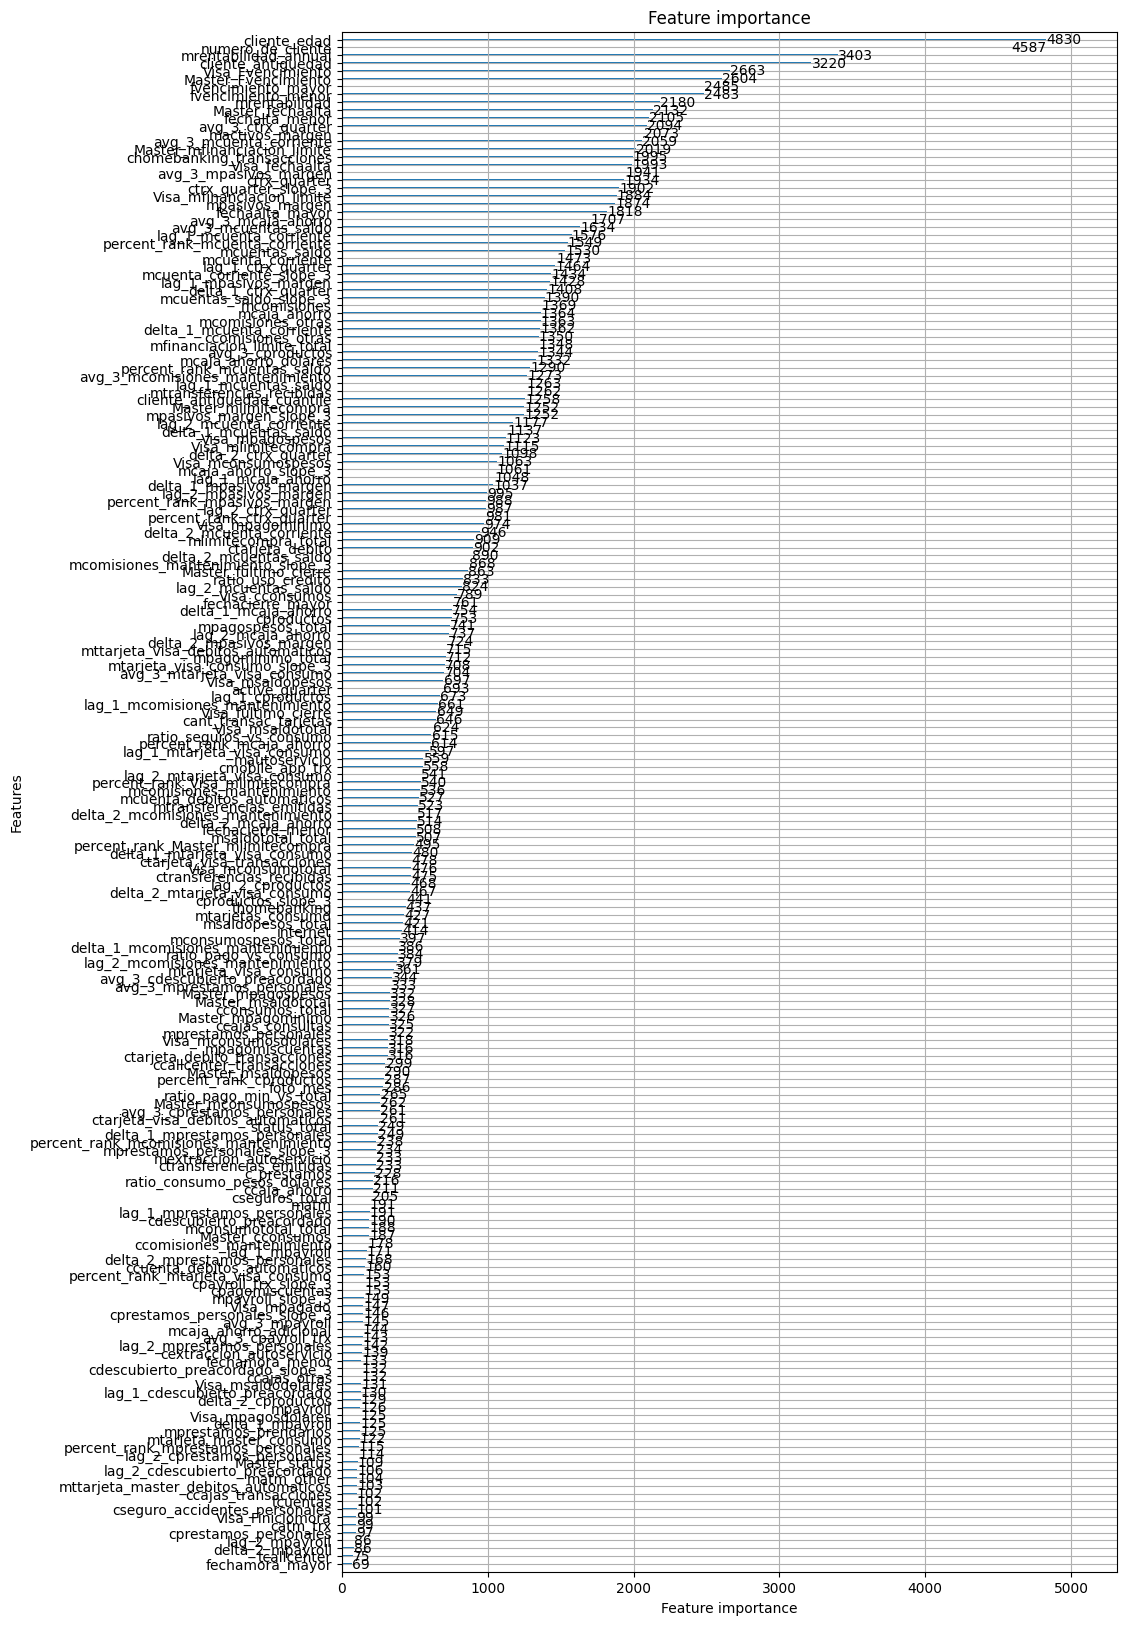

In [21]:
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [22]:
importances = model_lgb.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
0,cliente_edad,4830
1,numero_de_cliente,4587
2,mrentabilidad_annual,3403
3,cliente_antiguedad,3220
5,Visa_Fvencimiento,2663
...,...,...
184,cprestamos_personales,97
190,lag_2_mpayroll,86
183,delta_2_mpayroll,86
161,tcallcenter,75


In [29]:
top_200_features = importance_df["feature"].head(200).tolist()


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [23]:
model_lgb.save_model(modelos_path + 'lgb_tercero.txt')

Y recuperar el mismo desde ese formato

In [24]:
model_lgb = lgb.Booster(model_file=modelos_path + 'lgb_tercero.txt')

# Predicciones por probabilidad de darse de baja.

In [26]:
### todavia tengo que hacer por cantidad de envios y no por probabilidad. Si dejo prob > 0.025 le mando a 1600 personas nomas. Modifique la probabilidad para ver que onda pero no estaria entendiendo que pasa.
predicciones = model_lgb.predict(X_test)

clases = np.where(predicciones >= 0.0008, 1, 0)


resultados = pd.DataFrame({
    'numero_de_cliente': X_test['numero_de_cliente'],
    'Predicted': clases
})

In [27]:
resultados["Predicted"].value_counts()

Predicted
0    154798
1     10078
Name: count, dtype: int64

## Guardo la prediccion

In [28]:
predicciones = model_lgb.predict(X_test)

clases = np.where(predicciones >= 0.0008, 1, 0)

resultados = pd.DataFrame({
    'numero_de_cliente': X_test['numero_de_cliente'],
    'Predicted': clases
})

ruta_experimento="../../../exp/Competencia_1/"
nombre_exp="K1_010.csv"

resultados.to_csv(ruta_experimento+nombre_exp, index=False, sep=",")

## Subo a Kaggle

In [29]:
api = KaggleApi()
api.authenticate()
mensaje = "LGBM api, p> 0.0008... "
competencia = 'dm-ey-f-2024-primera'
api.competition_submit(file_name=ruta_experimento+nombre_exp,message=mensaje,competition=competencia)

100%|██████████| 2.08M/2.08M [00:01<00:00, 1.25MB/s]


Successfully submitted to DMEyF 2024 Primera